# Enefit - Predict Energy Behavior of Prosumers
<hr style="border:2px solid pink">

https://www.kaggle.com/competitions/predict-energy-behavior-of-prosumers/overview

From kaggle: 
The goal of the competition is to predict the amount of electricity produced and consumed by Estonian energy customers who have installed solar panels.

This competition aims to tackle the issue of energy imbalance, a situation where the energy expected to be used doesn't line up with the actual energy used or produced. Prosumers, who both consume and generate energy, contribute a large part of the energy imbalance. Despite being only a small part of all consumers, their unpredictable energy use causes logistical and financial problems for the energy companies.

Submissions are evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

# from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures

# from sklearn.impute import SimpleImputer, MissingIndicator
# from sklearn.compose import ColumnTransformer,  make_column_selector as selector
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score

# from sklearn.dummy import DummyClassifier, DummyRegressor
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import roc_auc_score
# from sklearn.metrics import classification_report

Load in the data.

In [2]:
client = pd.read_csv('../Data/client.csv')
county_id_to_name_map = pd.read_csv('../Data/county_id_to_name_map.json')
electricity_prices = pd.read_csv('../Data/electricity_prices.csv')
forecast_weather = pd.read_csv('../Data/forecast_weather.csv')
gas_prices = pd.read_csv('../Data/gas_prices.csv')
historical_weather = pd.read_csv('../Data/historical_weather.csv')
train = pd.read_csv('../Data/train.csv')
weather_station_to_county_mapping = pd.read_csv('../Data/weather_station_to_county_mapping.csv')

1. check out each file; do EDA, cleaning, visualizations, etc.
2. decide which files to use for modeling and/or if to join any.
3. save as csv.
4. begin modeling.

Understanding connections between the data: 
TRAIN, GAS_PRICES, CLIENT, ELECTRICITY_PRICES, FORECAST_WEATHER, HISTORICAL_WEATHER, THEN 2 MAPPING ONES

train

1. county (ID code for the county, corresponds to mapping for all)
2. is_business: 1 is yes, 0 is no
3. product_type: ID code for different contract types. 0 is combined, 1 is fixed, 2 is general services, 3 is spot. 
4. target: consumption/production amount for the relevent segment for the hour. The segments are defined by county, is_business, and product_type. So the total energy for each diff combo of county, business, product type, etc.
5. is_consumption: whether the rows target is consumption or production. 
6. datetime: describes the start of the 1-hour period on which the target is given. 
7. data_block_id: all rows sharing the same data_block_id will be available at the same forecast time. ????????
8. row_id: unique identifier for the row. 
9. prediction_unit_id: unique identifier for county, is_business, and product_type combo. 

gas_prices

10. origin_date: date when the day-ahead prices became available. 
11. forecast_date: date when the forecast prices are relevant. 
12. lowest/highest_price_per_mwh: min/max prices of natural gas on the ahead day, in euros per megawatt. 

client: 

13. eic_count: aggregated number of consumption points (eic = european identifier code)
14. installed_capacity: installed solar panel capacity in kilowatts. 
15. is_business: yes or no

electricity_prices

16. forecast_date: start of the 1-hour period when the price is valid. 
17. euros_per_mwh: price of electricity on the day ahead. 

forecast_weather

18. lat/longitude: coordinates of weather forecast. 
19. origin_datetime: timestamp when the forecast was generated. 
20. hours_ahead: number of hours between the forecast generation and the forecast weather. Each forecast covers a total of 48 hours. 
21. temperature: air temp at 2 meters above ground in celsius. Estimated for the end of the 1-hour period. 
22. dewpoint: dew point temp 2 meters above ground in celsius. Estimated for the end of the 1-hour period. 
23. cloudcover_low/mid/high/total: percent of the sky covered by clouds in the following altitude bands: 0-2, 2-6, 6+, and total (in km). Estimated for the end of the 1-hour period. 
24. 10_metre_u/v_wind_component: weed speed. Estimated for the end of the 1-hour period. 
25. forecast_datetime: timestamp for the predicted weather. Generated from origin_datetime + hours_ahead. Represents the start of the 1-hour period for which weather data is forecasted. 

historical_weather: 

26. datetime: start of the 1-hour period for which weather data is measured. 
27. temperature: measured at the end of the 1-hour period. 
28. dewpoint: measured at the end of the 1-hour period. 
29. rain, snowfall, cloudcover, windspeed, winddirection, radiation, are different in the different files. different scales. 

Check out each file. There are 8 total. 

##### File #1: Client
<hr style="border:2px solid pink">
from kaggle: 

- product_type
- county - An ID code for the county. See county_id_to_name_map.json for the mapping of ID codes to county names.
- eic_count - The aggregated number of consumption points (EICs - European Identifier Code).
- installed_capacity - Installed photovoltaic solar panel capacity in kilowatts.
- is_business - Boolean for whether or not the prosumer is a business.
- date
- data_block_id

In [3]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [4]:
client.info()
# no missing info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41919 entries, 0 to 41918
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_type        41919 non-null  int64  
 1   county              41919 non-null  int64  
 2   eic_count           41919 non-null  int64  
 3   installed_capacity  41919 non-null  float64
 4   is_business         41919 non-null  int64  
 5   date                41919 non-null  object 
 6   data_block_id       41919 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 2.2+ MB


In [5]:
client.isna().sum()
# confirmed no missing data

product_type          0
county                0
eic_count             0
installed_capacity    0
is_business           0
date                  0
data_block_id         0
dtype: int64

There is no missing data, but the date is an object. Changing it to datetime. 

In [6]:
# function to automatically convert to datetime

def convert_datetime(file, *columns): # *columns allows you to input diff amounts of columns
    for column in columns: # loop through each column listed and do the following
        file[column] = pd.to_datetime(file[column])
    return file.dtypes # return the dtypes so that we can confirm it worked

In [7]:
convert_datetime(client, 'date')

product_type                   int64
county                         int64
eic_count                      int64
installed_capacity           float64
is_business                    int64
date                  datetime64[ns]
data_block_id                  int64
dtype: object

Now date is in correct format. Confirm no duplicate entries. 

In [8]:
client.duplicated().sum()
# no duplicates

0

In [9]:
# look at the summary stats.
client.describe()

,product_type,county,eic_count,installed_capacity,is_business,data_block_id
count,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000,41919.000000
mean,1.898996,7.297097,73.345118,1450.771451,0.536773,322.898876
std,1.081713,4.780750,144.064389,2422.233120,0.498652,182.075724
min,0.000000,0.000000,5.000000,5.500000,0.000000,2.000000
25%,1.000000,3.000000,13.000000,321.900000,0.000000,167.000000
50%,2.000000,7.000000,32.000000,645.200000,1.000000,324.000000
75%,3.000000,11.000000,70.000000,1567.150000,1.000000,480.000000
max,3.000000,15.000000,1517.000000,19314.310000,1.000000,637.000000


Let's explore some patterns in the data

1. compare product_types to county, installed capacity, is business, date.
2. compare county to installed capacity
3. county vs is_business
4. is_business vs installed_capacity
5. explore dates - does month, year impact anything (compare to installed capacity, maybe certain months are more likely to have higher capacities)

In [10]:
client['product_type'].value_counts()
# 0: combined
# 1: fixed
# 2: general service
# 3: spot

3    19080
1    16232
0     3541
2     3066
Name: product_type, dtype: int64

In [11]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id
0,1,0,108,952.89,0,2021-09-01,2
1,2,0,17,166.40,0,2021-09-01,2
2,3,0,688,7207.88,0,2021-09-01,2
3,0,0,5,400.00,1,2021-09-01,2
4,1,0,43,1411.00,1,2021-09-01,2


In [12]:
client['date'].nunique()

636

In [13]:
# add a month and year column so we can look at trends
client['month'] = client['date'].dt.month
client['year'] = client['date'].dt.year
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,month,year
0,1,0,108,952.89,0,2021-09-01,2,9,2021
1,2,0,17,166.40,0,2021-09-01,2,9,2021
2,3,0,688,7207.88,0,2021-09-01,2,9,2021
3,0,0,5,400.00,1,2021-09-01,2,9,2021
4,1,0,43,1411.00,1,2021-09-01,2,9,2021


In [57]:
# data contains 4 months of 2021, all of 2022, and 5 months of 2023. 
client.groupby(['year', 'month'])['installed_capacity'].mean()

year  month
2021  9        1158.459454
      10       1175.036487
      11       1167.548571
      12       1182.550666
2022  1        1141.587717
      2        1157.800862
      3        1191.310029
      4        1212.701915
      5        1260.965017
      6        1320.063930
      7        1415.060709
      8        1471.529169
      9        1512.972090
      10       1546.584478
      11       1569.241932
      12       1661.399355
2023  1        1705.511576
      2        1747.738365
      3        1814.143414
      4        1888.725633
      5        2125.853233
Name: installed_capacity, dtype: float64

In [54]:
# average installed capacity grouped by year and month
# set as dataframe to make visualizations easier

client_year = pd.DataFrame(client.groupby('year')['installed_capacity'].mean())
client_month = pd.DataFrame(client.groupby('month')['installed_capacity'].mean())
client_month_year = pd.DataFrame(client.groupby(['month', 'year'])['installed_capacity'].mean())

In [55]:
client_year

,installed_capacity
year,
2021,1171.127106
2022,1374.430980
2023,1854.960169


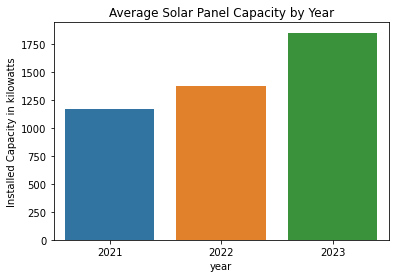

In [60]:
sns.barplot(data=client_year, x=client_year.index, y='installed_capacity')
plt.title('Average Solar Panel Capacity by Year')
plt.ylabel('Installed Capacity in kilowatts')
plt.show();

In [61]:
# even though there is less data in 2023, there is more installed capacity than in prior years. 

In [64]:
client['is_business'].value_counts()

1    22501
0    19418
Name: is_business, dtype: int64

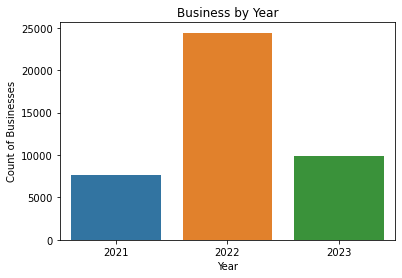

In [71]:
sns.barplot(data=pd.DataFrame(client.groupby('year')['is_business'].count()), 
           x=['2021', '2022', '2023'], 
           y='is_business')
plt.title('Business by Year')
plt.ylabel('Count of Businesses')
plt.xlabel('Year')
plt.show();

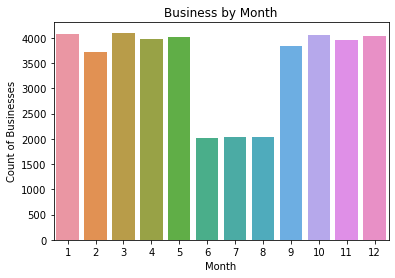

In [88]:
sns.barplot(data=pd.DataFrame(client.groupby('month')['is_business'].count()), 
           x=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'], 
           y='is_business')
plt.title('Business by Month')
plt.ylabel('Count of Businesses')
plt.xlabel('Month')
plt.show();

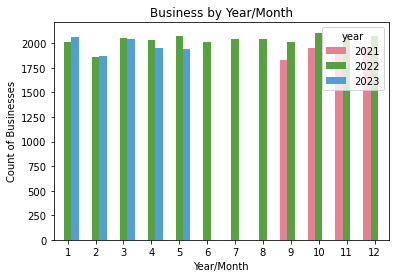

In [149]:
business_ym = pd.DataFrame(client.groupby(['year', 'month'])['is_business'].count())
business_ym.reset_index(inplace=True)

sns.barplot(data=business_ym, x='month', y='is_business', hue='year', palette='husl')
plt.title('Business by Year/Month')
plt.ylabel('Count of Businesses')
plt.xlabel('Year/Month')
plt.show();

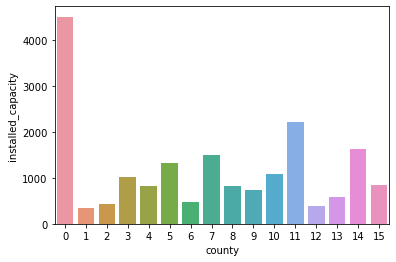

In [152]:
avg_county_capacity = pd.DataFrame(client.groupby('county')['installed_capacity'].mean())
sns.barplot(data=avg_county_capacity, x=avg_county_capacity.index, y='installed_capacity')
plt.show();

In [ ]:
# county 0 has the most installed capacity

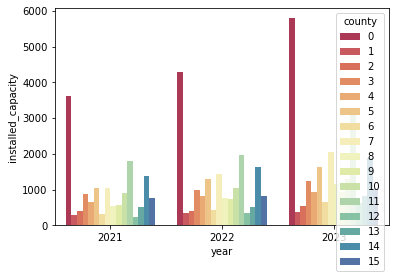

In [157]:
avg_county_year = pd.DataFrame(client.groupby(['county', 'year'])['installed_capacity'].mean())
avg_county_year.reset_index(inplace=True)

sns.barplot(data=avg_county_year, x='year', y='installed_capacity', hue='county', palette='Spectral')
plt.show()

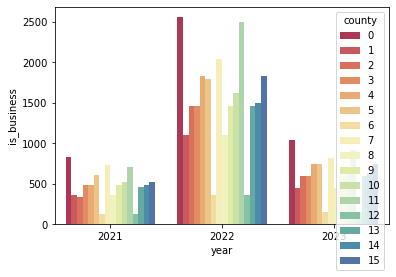

In [159]:
count_county_year_bus = pd.DataFrame(client.groupby(['county', 'year'])['is_business'].count())
count_county_year_bus.reset_index(inplace=True)

sns.barplot(data=count_county_year_bus, x='year', y='is_business', hue='county', palette='Spectral')
plt.show();

In [72]:
client.head()

,product_type,county,eic_count,installed_capacity,is_business,date,data_block_id,month,year
0,1,0,108,952.89,0,2021-09-01,2,9,2021
1,2,0,17,166.40,0,2021-09-01,2,9,2021
2,3,0,688,7207.88,0,2021-09-01,2,9,2021
3,0,0,5,400.00,1,2021-09-01,2,9,2021
4,1,0,43,1411.00,1,2021-09-01,2,9,2021


##### File #2: county_id_to_name_map
<hr style="border:2px solid pink">

In [10]:
county_id_to_name_map

,"{""0"":""HARJUMAA""","1:""HIIUMAA""","2:""IDA-VIRUMAA""","3:""J\u00c4RVAMAA""","4:""J\u00d5GEVAMAA""","5:""L\u00c4\u00c4NE-VIRUMAA""","6:""L\u00c4\u00c4NEMAA""","7:""P\u00c4RNUMAA""","8:""P\u00d5LVAMAA""","9:""RAPLAMAA""","10:""SAAREMAA""","11:""TARTUMAA""","12:""UNKNOWN""","13:""VALGAMAA""","14:""VILJANDIMAA""","15:""V\u00d5RUMAA""}"


Might need to clean up the indexes. Okay for now. Moving on

##### File #3: electricity_prices: 
<hr style="border:2px solid pink">
- origin_date
- forecast_date - Represents the start of the 1-hour period when the price is valid
- euros_per_mwh - The price of electricity on the day ahead markets in euros per megawatt hour.
- data_block_id

In [11]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


In [12]:
electricity_prices.info()
# no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15286 entries, 0 to 15285
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   forecast_date  15286 non-null  object 
 1   euros_per_mwh  15286 non-null  float64
 2   origin_date    15286 non-null  object 
 3   data_block_id  15286 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 477.8+ KB


Forecast date and origin date are objects, let's change to datetime. 

In [13]:
convert_datetime(electricity_prices, 'forecast_date', 'origin_date')

forecast_date    datetime64[ns]
euros_per_mwh           float64
origin_date      datetime64[ns]
data_block_id             int64
dtype: object

In [14]:
# good now check no missing values and duplicates
electricity_prices.isna().sum()

forecast_date    0
euros_per_mwh    0
origin_date      0
data_block_id    0
dtype: int64

In [15]:
electricity_prices.duplicated().sum()

0

In [16]:
# summary stats
electricity_prices.describe()

,euros_per_mwh,data_block_id
count,15286.000000,15286.000000
mean,157.064176,318.990710
std,121.148625,183.890301
min,-10.060000,1.000000
25%,85.290000,160.000000
50%,128.280000,319.000000
75%,199.797500,478.000000
max,4000.000000,637.000000


In [17]:
electricity_prices.head()

,forecast_date,euros_per_mwh,origin_date,data_block_id
0,2021-09-01 00:00:00,92.51,2021-08-31 00:00:00,1
1,2021-09-01 01:00:00,88.90,2021-08-31 01:00:00,1
2,2021-09-01 02:00:00,87.35,2021-08-31 02:00:00,1
3,2021-09-01 03:00:00,86.88,2021-08-31 03:00:00,1
4,2021-09-01 04:00:00,88.43,2021-08-31 04:00:00,1


To explore: 
1. forecast date vs euros per mwh

##### File #4:  forecast_weather
<hr style="border:2px solid pink">

In [18]:
forecast_weather.head()

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 02:00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 02:00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 02:00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 02:00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 02:00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 03:00:00,0.0,0.0,0.0,0.0


In [19]:
forecast_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3424512 entries, 0 to 3424511
Data columns (total 18 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   latitude                           float64
 1   longitude                          float64
 2   origin_datetime                    object 
 3   hours_ahead                        int64  
 4   temperature                        float64
 5   dewpoint                           float64
 6   cloudcover_high                    float64
 7   cloudcover_low                     float64
 8   cloudcover_mid                     float64
 9   cloudcover_total                   float64
 10  10_metre_u_wind_component          float64
 11  10_metre_v_wind_component          float64
 12  data_block_id                      int64  
 13  forecast_datetime                  object 
 14  direct_solar_radiation             float64
 15  surface_solar_radiation_downwards  float64
 16  snowfall          

In [20]:
convert_datetime(forecast_weather, 'origin_datetime', 'forecast_datetime')

latitude                                    float64
longitude                                   float64
origin_datetime                      datetime64[ns]
hours_ahead                                   int64
temperature                                 float64
dewpoint                                    float64
cloudcover_high                             float64
cloudcover_low                              float64
cloudcover_mid                              float64
cloudcover_total                            float64
10_metre_u_wind_component                   float64
10_metre_v_wind_component                   float64
data_block_id                                 int64
forecast_datetime                    datetime64[ns]
direct_solar_radiation                      float64
surface_solar_radiation_downwards           float64
snowfall                                    float64
total_precipitation                         float64
dtype: object

In [21]:
# check for N/A
forecast_weather.isna().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    2
snowfall                             0
total_precipitation                  0
dtype: int64

In [22]:
# 2 missing values in surface solar radiation downwards. 
# 3 million rows, let's drop the missing values
forecast_weather['surface_solar_radiation_downwards'].isna().sum()

2

In [23]:
forecast_weather.dropna(inplace=True)

In [24]:
# no more missing values
forecast_weather.isna().sum()

latitude                             0
longitude                            0
origin_datetime                      0
hours_ahead                          0
temperature                          0
dewpoint                             0
cloudcover_high                      0
cloudcover_low                       0
cloudcover_mid                       0
cloudcover_total                     0
10_metre_u_wind_component            0
10_metre_v_wind_component            0
data_block_id                        0
forecast_datetime                    0
direct_solar_radiation               0
surface_solar_radiation_downwards    0
snowfall                             0
total_precipitation                  0
dtype: int64

In [25]:
# no duplicated values
forecast_weather.duplicated().sum()

0

In [26]:
# summary stats
forecast_weather.describe()

,latitude,longitude,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
count,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06,3.424510e+06
mean,5.865000e+01,2.495000e+01,2.450001e+01,5.743905e+00,2.411938e+00,3.946651e-01,4.346456e-01,3.590696e-01,6.819926e-01,1.255444e+00,7.250068e-01,3.190000e+02,1.511882e+02,1.107642e+02,2.533924e-05,7.863864e-05
std,6.873862e-01,2.015565e+00,1.385340e+01,7.844201e+00,7.121425e+00,4.440425e-01,4.386346e-01,4.201556e-01,4.009630e-01,3.995300e+00,4.223749e+00,1.838859e+02,2.565070e+02,1.874444e+02,1.222840e-04,2.780880e-04
min,5.760000e+01,2.170000e+01,1.000000e+00,-2.749940e+01,-2.968357e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.757718e+01,-2.211612e+01,1.000000e+00,-7.733333e-01,-3.258333e-01,-3.814697e-06,-1.529098e-05
25%,5.797500e+01,2.320000e+01,1.300000e+01,2.606445e-01,-2.364355e+00,0.000000e+00,3.356934e-04,0.000000e+00,2.648926e-01,-1.466692e+00,-1.978116e+00,1.600000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.850000e+01,2.520000e+01,2.500000e+01,4.872705e+00,1.835596e+00,8.866882e-02,2.305491e-01,1.011963e-01,9.772680e-01,1.468679e+00,9.433179e-01,3.190000e+02,0.000000e+00,6.044444e-01,0.000000e+00,0.000000e+00
75%,5.910000e+01,2.670000e+01,3.675000e+01,1.114639e+01,7.302026e+00,9.784851e-01,9.994587e-01,9.000854e-01,1.000000e+00,3.813527e+00,3.507623e+00,4.780000e+02,2.128451e+02,1.441723e+02,0.000000e+00,2.765656e-05
max,5.970000e+01,2.820000e+01,4.800000e+01,3.181069e+01,2.368057e+01,1.000008e+00,1.000008e+00,1.000008e+00,1.000008e+00,2.257320e+01,1.931437e+01,6.370000e+02,9.544222e+02,8.487144e+02,4.832983e-03,1.651621e-02


Visualizations here: there's a lot that can be compared

##### File #5: gas_prices
<hr style="border:2px solid pink">

In [27]:
gas_prices.head()

,forecast_date,lowest_price_per_mwh,highest_price_per_mwh,origin_date,data_block_id
0,2021-09-01,45.23,46.32,2021-08-31,1
1,2021-09-02,45.62,46.29,2021-09-01,2
2,2021-09-03,45.85,46.40,2021-09-02,3
3,2021-09-04,46.30,46.80,2021-09-03,4
4,2021-09-05,46.30,46.58,2021-09-04,5


In [28]:
gas_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 637 entries, 0 to 636
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   forecast_date          637 non-null    object 
 1   lowest_price_per_mwh   637 non-null    float64
 2   highest_price_per_mwh  637 non-null    float64
 3   origin_date            637 non-null    object 
 4   data_block_id          637 non-null    int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 25.0+ KB


In [29]:
convert_datetime(gas_prices, 'forecast_date', 'origin_date')

forecast_date            datetime64[ns]
lowest_price_per_mwh            float64
highest_price_per_mwh           float64
origin_date              datetime64[ns]
data_block_id                     int64
dtype: object

In [30]:
# no missing prices or duplicates
gas_prices.isna().sum()

forecast_date            0
lowest_price_per_mwh     0
highest_price_per_mwh    0
origin_date              0
data_block_id            0
dtype: int64

In [31]:
gas_prices.duplicated().sum()

0

In [32]:
gas_prices.describe()

,lowest_price_per_mwh,highest_price_per_mwh,data_block_id
count,637.000000,637.000000,637.000000
mean,95.036750,107.754631,319.000000
std,47.552295,54.743666,184.030342
min,28.100000,34.000000,1.000000
25%,60.000000,67.530000,160.000000
50%,85.210000,93.470000,319.000000
75%,109.000000,130.740000,478.000000
max,250.000000,305.000000,637.000000


visualizations: 

##### File #6: historical_weather
<hr style="border:2px solid pink">

In [33]:
historical_weather.head()

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01 00:00:00,14.2,11.6,0.0,0.0,1015.9,31,31,0,11,7.083333,8,0.0,0.0,0.0,57.6,21.7,1.0
1,2021-09-01 00:00:00,13.9,11.5,0.0,0.0,1010.7,33,37,0,0,5.111111,359,0.0,0.0,0.0,57.6,22.2,1.0
2,2021-09-01 00:00:00,14.0,12.5,0.0,0.0,1015.0,31,34,0,0,6.333333,355,0.0,0.0,0.0,57.6,22.7,1.0
3,2021-09-01 00:00:00,14.6,11.5,0.0,0.0,1017.3,0,0,0,0,8.083333,297,358.0,277.0,81.0,57.6,23.2,1.0
4,2021-09-01 00:00:00,15.7,12.9,0.0,0.0,1014.0,22,25,0,0,8.416667,5,0.0,0.0,0.0,57.6,23.7,1.0


In [34]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710802 entries, 0 to 1710801
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   datetime                object 
 1   temperature             float64
 2   dewpoint                float64
 3   rain                    float64
 4   snowfall                float64
 5   surface_pressure        float64
 6   cloudcover_total        int64  
 7   cloudcover_low          int64  
 8   cloudcover_mid          int64  
 9   cloudcover_high         int64  
 10  windspeed_10m           float64
 11  winddirection_10m       int64  
 12  shortwave_radiation     float64
 13  direct_solar_radiation  float64
 14  diffuse_radiation       float64
 15  latitude                float64
 16  longitude               float64
 17  data_block_id           float64
dtypes: float64(12), int64(5), object(1)
memory usage: 234.9+ MB


In [35]:
convert_datetime(historical_weather, 'datetime')

datetime                  datetime64[ns]
temperature                      float64
dewpoint                         float64
rain                             float64
snowfall                         float64
surface_pressure                 float64
cloudcover_total                   int64
cloudcover_low                     int64
cloudcover_mid                     int64
cloudcover_high                    int64
windspeed_10m                    float64
winddirection_10m                  int64
shortwave_radiation              float64
direct_solar_radiation           float64
diffuse_radiation                float64
latitude                         float64
longitude                        float64
data_block_id                    float64
dtype: object

In [36]:
# check missing and duplicates
historical_weather.isna().sum()

datetime                  0
temperature               0
dewpoint                  0
rain                      0
snowfall                  0
surface_pressure          0
cloudcover_total          0
cloudcover_low            0
cloudcover_mid            0
cloudcover_high           0
windspeed_10m             0
winddirection_10m         0
shortwave_radiation       0
direct_solar_radiation    0
diffuse_radiation         0
latitude                  0
longitude                 0
data_block_id             0
dtype: int64

In [37]:
historical_weather.duplicated().sum()

0

In [38]:
historical_weather.describe()

,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
count,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06,1.710802e+06
mean,5.740968e+00,2.240312e+00,4.962012e-02,1.604896e-02,1.009282e+03,6.091270e+01,4.668593e+01,3.440698e+01,3.605141e+01,4.849871e+00,1.978694e+02,1.064905e+02,6.445292e+01,4.203759e+01,5.865000e+01,2.495000e+01,3.192708e+02
std,8.025647e+00,7.224357e+00,2.079113e-01,7.462936e-02,1.308891e+01,3.776905e+01,4.074760e+01,3.832769e+01,4.135852e+01,2.475450e+00,8.993798e+01,1.799449e+02,1.334100e+02,6.195225e+01,6.873871e-01,2.015564e+00,1.837298e+02
min,-2.370000e+01,-2.590000e+01,0.000000e+00,0.000000e+00,9.429000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.760000e+01,2.170000e+01,1.000000e+00
25%,-0.000000e+00,-2.600000e+00,0.000000e+00,0.000000e+00,1.001500e+03,2.500000e+01,3.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,1.390000e+02,0.000000e+00,0.000000e+00,0.000000e+00,5.790000e+01,2.320000e+01,1.600000e+02
50%,5.100000e+00,1.700000e+00,0.000000e+00,0.000000e+00,1.010400e+03,7.200000e+01,3.900000e+01,1.600000e+01,1.000000e+01,4.500000e+00,2.080000e+02,1.000000e+00,0.000000e+00,1.000000e+00,5.850000e+01,2.470000e+01,3.190000e+02
75%,1.120000e+01,7.200000e+00,0.000000e+00,0.000000e+00,1.018000e+03,1.000000e+02,9.400000e+01,7.200000e+01,8.500000e+01,6.277778e+00,2.630000e+02,1.400000e+02,4.700000e+01,7.400000e+01,5.910000e+01,2.670000e+01,4.780000e+02
max,3.260000e+01,2.380000e+01,1.680000e+01,2.660000e+00,1.049300e+03,1.000000e+02,1.000000e+02,1.000000e+02,1.000000e+02,2.175000e+01,3.600000e+02,8.490000e+02,7.540000e+02,3.880000e+02,5.970000e+01,2.820000e+01,6.370000e+02


visualizations: 

##### File #7: Train
<hr style="border:2px solid pink">

In [39]:
train.head()

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
0,0,0,1,0.713,0,2021-09-01 00:00:00,0,0,0
1,0,0,1,96.590,1,2021-09-01 00:00:00,0,1,0
2,0,0,2,0.000,0,2021-09-01 00:00:00,0,2,1
3,0,0,2,17.314,1,2021-09-01 00:00:00,0,3,1
4,0,0,3,2.904,0,2021-09-01 00:00:00,0,4,2


In [40]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2018352 entries, 0 to 2018351
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   county              int64  
 1   is_business         int64  
 2   product_type        int64  
 3   target              float64
 4   is_consumption      int64  
 5   datetime            object 
 6   data_block_id       int64  
 7   row_id              int64  
 8   prediction_unit_id  int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 138.6+ MB


In [41]:
convert_datetime(train, 'datetime')

county                         int64
is_business                    int64
product_type                   int64
target                       float64
is_consumption                 int64
datetime              datetime64[ns]
data_block_id                  int64
row_id                         int64
prediction_unit_id             int64
dtype: object

In [42]:
train.isna().sum()
# target is missing 528 values
# 2 million rows, drop them

county                  0
is_business             0
product_type            0
target                528
is_consumption          0
datetime                0
data_block_id           0
row_id                  0
prediction_unit_id      0
dtype: int64

In [43]:
train.shape

(2018352, 9)

In [44]:
train.dropna(inplace=True)
train.shape

(2017824, 9)

In [45]:
# check duplicates
train.duplicated().sum()

0

In [46]:
train.describe()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
count,2.017824e+06,2.017824e+06,2.017824e+06,2.017824e+06,2017824.0,2.017824e+06,2.017824e+06,2.017824e+06
mean,7.297039e+00,5.368268e-01,1.898927e+00,2.748556e+02,0.5,3.218754e+02,1.009178e+06,3.304540e+01
std,4.780994e+00,4.986421e-01,1.081766e+00,9.095024e+02,0.5,1.826310e+02,5.826378e+05,1.959062e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,0.000000e+00,1.000000e+00,3.780000e-01,0.0,1.660000e+02,5.045818e+05,1.600000e+01
50%,7.000000e+00,1.000000e+00,2.000000e+00,3.113300e+01,0.5,3.230000e+02,1.009172e+06,3.300000e+01
75%,1.100000e+01,1.000000e+00,3.000000e+00,1.802062e+02,1.0,4.790000e+02,1.513763e+06,5.000000e+01
max,1.500000e+01,1.000000e+00,3.000000e+00,1.548027e+04,1.0,6.370000e+02,2.018351e+06,6.800000e+01


visualizations: 

##### File #8: weather_station_to_county_mapping
<hr style="border:2px solid pink">

In [47]:
weather_station_to_county_mapping.head()

,county_name,longitude,latitude,county
0,NaN,21.7,57.6,NaN
1,NaN,21.7,57.9,NaN
2,NaN,21.7,58.2,NaN
3,NaN,21.7,58.5,NaN
4,NaN,21.7,58.8,NaN


In [48]:
weather_station_to_county_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112 entries, 0 to 111
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   county_name  49 non-null     object 
 1   longitude    112 non-null    float64
 2   latitude     112 non-null    float64
 3   county       49 non-null     float64
dtypes: float64(3), object(1)
memory usage: 3.6+ KB


In [49]:
# county name and county are missing about half the values
# can't drop them
# is this file useful

In [50]:
weather_station_to_county_mapping.isna().sum()

county_name    63
longitude       0
latitude        0
county         63
dtype: int64

In [51]:
weather_station_to_county_mapping.duplicated().sum()

0

In [52]:
weather_station_to_county_mapping.describe()

,longitude,latitude,county
count,112.000000,112.000000,49.000000
mean,24.950000,58.650000,7.061224
std,2.024623,0.690476,4.870866
min,21.700000,57.600000,0.000000
25%,23.200000,58.125000,3.000000
50%,24.950000,58.650000,7.000000
75%,26.700000,59.175000,11.000000
max,28.200000,59.700000,15.000000
